In [1]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc
import geopandas as gpd
import h3
import pandas as pd

import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
import rasterio.mask

import numpy as np
from PIL import Image

from shapely.geometry import Point

from tqdm import tqdm

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/.local/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/edgaregurrola/.local/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Download data

### Municipality GeoDataFrame

(10, 6)


<AxesSubplot:>

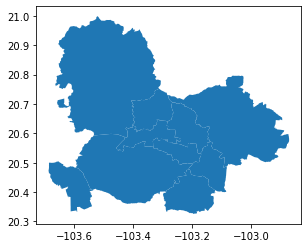

In [4]:
city = 'Guadalajara'
query = f"SELECT * FROM metropolis.metro_list WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')
print(mun_gdf.shape)
mun_gdf.plot()

### Hex-bins GeoDataFrame

In [ ]:
mpos = list(mun_gdf.CVEGEO.unique())

hex_ageb = gpd.GeoDataFrame()

schema = 'censo'
folder = 'hex_bins_pop_2020'

for m in mpos:
    query = f"SELECT hex_id_8,geometry FROM {schema}.{folder} WHERE \"CVEGEO\" LIKE \'{m}%%\'"
    hex_ageb = pd.concat([hex_ageb, 
                          aup.gdf_from_query(query, geometry_col='geometry')], 
                         ignore_index = True, axis = 0)

print(hex_ageb.shape)
hex_ageb.plot()

## Humidity index analysis

### Gather random hex-bin

In [4]:
hex_analysis = hex_ageb.sample(1)

In [ ]:
hex_analysis = hex_ageb.loc[hex_ageb.hex_id_8 == '8849ab4b6dfffff']

In [ ]:
hex_indexes = str(tuple(h3.h3_to_children(hex_analysis.hex_id_8.values[0], 9)))
schema = 'hexgrid' 
table = 'hexgrid_9'
query = f'SELECT hex_id_9,geometry FROM {schema}.{table} WHERE "hex_id_9" IN {hex_indexes}'
hex_analysis_res9 = aup.gdf_from_query(query, geometry_col='geometry')
print(hex_analysis_res9.shape)
hex_analysis_res9.plot()

### Create boundaries for imagery download

In [ ]:
# Reads mun_gdf GeoDataFrame as polygon
poly = hex_analysis.geometry
# Extracts coordinates from polygon as DataFrame
coord_val = poly.bounds
# Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

#### Generate polygon dictionary

In [ ]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [e, s],
            [w, s],
            [w, n],
            [e, n],
            [e, s],
        ]
    ],
}

### Define time period for imagery

In [ ]:
time_of_interest = "2020-01-01/2021-12-31"

### Identify imagery

This section identifies satellite imagery that meets the requeirments for the Satellite (sentinel-2-l2a), area_of_interest, time_of_interest and limit for cloud cover (10%).

In [ ]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

# Check how many items were returned
items = list(search.get_items())
print(f"Returned {len(items)} Items")

### Gather links for imagery bands

Identify download links for Near Infrared (nir) and Green bands for each date that meets the requierments.

In [ ]:
def find_asset_by_band_common_name(item, common_name):
    for asset in item.assets.values():
        asset_bands = eo.ext(asset).bands
        if asset_bands and asset_bands[0].common_name == common_name:
            return asset
    raise KeyError(f"{common_name} band not found")

In [ ]:
assets_hrefs = {}

for i in items:
    assets_hrefs[i.datetime.date()] = [pc.sign(find_asset_by_band_common_name(i,"rededge").href)]
    assets_hrefs[i.datetime.date()].append(pc.sign(find_asset_by_band_common_name(i,"swir16").href))

## Raster to points

Transform pixel from raster to points with NDVI values.

In [12]:
def raster_to_point(href, gdf):
    
    with rasterio.open(href) as ds:

        gdf_tmp = gdf.copy()
        gdf_tmp = gdf_tmp.to_crs("EPSG:"+str(ds.crs.to_epsg()))
        gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
        poly_mask = gdf_tmp.dissolve().geometry

        out_mask, out_transform = rasterio.mask.mask(ds, poly_mask, crop=True)
        out_meta = ds.meta
        
        ds.close()

    out_meta.update({"driver": "GTiff",
                     "height": out_mask.shape[1],
                     "width": out_mask.shape[2],
                     "transform": out_transform})

    with rasterio.open("tmp/masked.tif", "w", **out_meta) as dest:
        dest.write(out_mask)
        
        dest.close()

    with rasterio.open("tmp/masked.tif", "r", **out_meta) as src:

        val = src.read(1)
        no_data=src.nodata
        geometry = [Point(src.xy(x,y)[0],src.xy(x,y)[1]) 
                    for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
        v = [val[x,y] for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
        gdf = gpd.GeoDataFrame({'geometry':geometry,'data':v})
        gdf.crs = src.crs
        
        src.close()
        
    return gdf

In [158]:
ndvi_dict = {}

for k in tqdm(assets_hrefs.keys(), position=0, leave=True):
    g = raster_to_point(assets_hrefs[k][0], hex_analysis) # green band
    nir = raster_to_point(assets_hrefs[k][1], hex_analysis) # near-infrared band
    ndvi_gdf = g.merge(nir[['data']], left_index=True, right_index=True)
    ndvi_gdf.rename(columns={'data_x':'rededge','data_y':'swir16'}, inplace=True)
    ndvi_gdf['humidity_idx'] = (ndvi_gdf['rededge']-ndvi_gdf['swir16'])/(ndvi_gdf['rededge']+ndvi_gdf['swir16'])
    ndvi_gdf = ndvi_gdf.to_crs("EPSG:4326")
    
    for hex_idx in hex_analysis_res9.hex_id_9:
        hex_tmp = hex_analysis_res9.loc[hex_analysis_res9.hex_id_9==hex_idx]
        clipped_ndvi = gpd.clip(ndvi_gdf_tmp, hex_tmp)
        
        if hex_idx in ndvi_dict.keys():
            ndvi_dict[hex_idx].append(clipped_ndvi.ndvi.mean())
        else:
            ndvi_dict[hex_idx] = []
            ndvi_dict[hex_idx].append(clipped_ndvi.ndvi.mean())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [04:52<00:00,  4.06s/it]


In [159]:
for hex_idx in ndvi_dict.keys():
    ndvi_dict[hex_idx] = sum(ndvi_dict[hex_idx]) / len(ndvi_dict[hex_idx])

In [162]:
ndvi_dict

{'8949aa2c233ffff': 0.508688197942885,
 '8949aa2c22fffff': 0.4667339273457528,
 '8949aa2c223ffff': 0.4946046939660508,
 '8949aa2c23bffff': 0.43145972525365317,
 '8949aa2c237ffff': 0.5032111018116076,
 '8949aa2c22bffff': 0.3621553174656935,
 '8949aa2c227ffff': 0.47060359360140347}

In [167]:
hex_ndvi_res9 = pd.DataFrame.from_dict(ndvi_dict, 
                       orient='index').reset_index().rename(
    columns={'index':'hex_id_9', 0:'ndvi'})
hex_ndvi_res9 = pd.merge(hex_analysis_res9, hex_ndvi_res9, on='hex_id_9')

<AxesSubplot:>

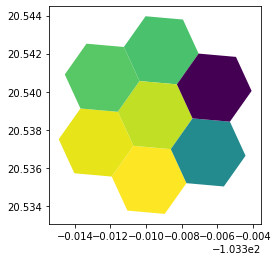

In [168]:
hex_ndvi_res9.plot('ndvi')

In [173]:
sum(ndvi_dict.values()) /len(ndvi_dict.values())

0.4624937939124351